# Deep learning

Last updated 30 Dec 2022

Given the highly nonlinear relationships between measurements in chromatin accessibility and gene expressions across millions of gene locations, we require a "heavier duty" supervised machine learning model. A deep neural network is well suited to this task.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
import sklearn.model_selection
import scipy

import gc

import tensorflow as tf
print(tf.__version__)

2022-12-30 10:59:30.116191: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2.9.1


In [2]:
df_multiome_train_x = scipy.sparse.load_npz("/home/jovyan/project/Processed Data/df_multiome_train_x.npz")
df_multiome_train_y = scipy.sparse.load_npz("/home/jovyan/project/Processed Data/df_multiome_train_y.npz")
df_multiome_test_x = scipy.sparse.load_npz("/home/jovyan/project/Processed Data/df_multiome_test_x.npz")

In [3]:
# train inputs: 105942 * 228942 float32 values (97 GByte)
# train targets: 105942 * 23418 float32 values (10 GByte)
# test inputs: 55935 * 228942 float32 values (13 GByte)

up_tp_row = 100000
up_to_col = 2000

df_multiome_train_x = df_multiome_train_x[:up_tp_row,:up_to_col]
df_multiome_train_y = df_multiome_train_y[:up_tp_row,:up_to_col]
df_multiome_test_x = df_multiome_test_x[:up_tp_row,:up_to_col]

In [4]:
input_dimensions = df_multiome_train_x.shape[1]
output_dimensions = df_multiome_train_y.shape[1]

In [5]:
train_X, valid_X, train_y, valid_y = sklearn.model_selection.train_test_split(df_multiome_train_x, df_multiome_train_y,
                                                                              test_size = 0.33, random_state = 20221126)

In [6]:
# remove dataframes no longer required to free up space
# del [[df_multiome_train_x, df_multiome_train_y]]
gc.collect()

187

## 1. First run

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

### a. Define model

In [8]:
model = keras.Sequential(
    [
        # input layer
        layers.Dense(units = 1024, activation = "relu", input_shape = [input_dimensions]),
        layers.BatchNormalization(),
        
        # hidden layers
        layers.Dense(units = 1024, activation = "relu"),
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        layers.Dense(units = 1024, activation = "relu"),
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        layers.Dense(units = 1024, activation = "relu"),
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        layers.Dense(units = 1024, activation = "relu"),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        
        layers.Dense(units = 1024, activation = "relu"),
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        layers.Dense(units = 1024, activation = "relu"),
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        # output layer
        layers.Dense(output_dimensions)
    ]
)  

2022-12-30 11:00:33.976055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-30 11:00:33.982210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-30 11:00:33.982856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-30 11:00:33.983750: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

### b. Compile model

In [9]:
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [
        tf.keras.metrics.Accuracy(), 
        tf.keras.metrics.MeanSquaredError(), 
        tf.keras.metrics.RootMeanSquaredError(), 
        tf.keras.metrics.CosineSimilarity(axis = 1)
        ]
)

### c. Fit model

In [10]:
early_stopping_mechanism = EarlyStopping(
    min_delta = 0.0001,
    patience = 10,
    restore_best_weights = True
)

model_fit = model.fit(
    train_X, train_y.toarray(),
    validation_data = (valid_X, valid_y.toarray()),

    batch_size = 64,
    epochs = 1000,
    callbacks = [early_stopping_mechanism]
)

Epoch 1/1000


/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 1024), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


1047/1047 [==============================] - 15s 12ms/step - loss: 0.6528 - accuracy: 7.4627e-09 - mean_squared_error: 0.6528 - root_mean_squared_error: 0.8080 - cosine_similarity: 0.4186 - val_loss: 0.5983 - val_accuracy: 1.5152e-08 - val_mean_squared_error: 0.5983 - val_root_mean_squared_error: 0.7735 - val_cosine_similarity: 0.4636
Epoch 2/1000
1047/1047 [==============================] - 12s 11ms/step - loss: 0.5898 - accuracy: 7.4627e-09 - mean_squared_error: 0.5898 - root_mean_squared_error: 0.7680 - cosine_similarity: 0.4671 - val_loss: 0.5846 - val_accuracy: 4.5455e-08 - val_mean_squared_error: 0.5846 - val_root_mean_squared_error: 0.7646 - val_cosine_similarity: 0.4727
Epoch 3/1000
1047/1047 [==============================] - 12s 11ms/step - loss: 0.5791 - accuracy: 1.4925e-08 - mean_squared_error: 0.5791 - root_mean_squared_error: 0.7610 - cosine_similarity: 0.4772 - val_loss: 0.5771 - val_accuracy: 6.0606e-08 - val_mean_squared_error: 0.5771 - val_root_mean_squared_error: 0.

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              2049024   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1024)              1

In [12]:
model.save("attempt_1.h5")

In [13]:
# load saved model
# model = load_model('attempt_1.h5')

### d. Evaluate model

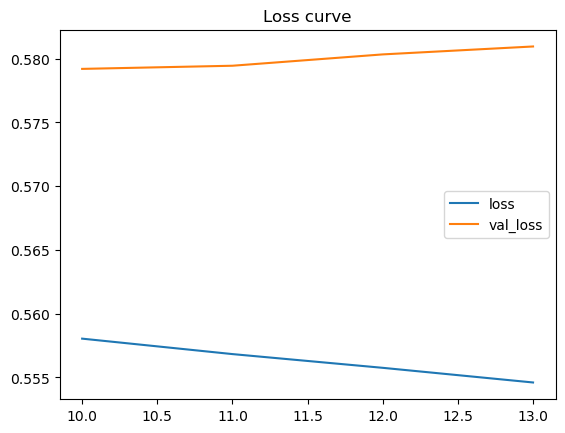

Minimum validation loss: 0.5765097737312317


In [14]:
pd.DataFrame(model_fit.history).loc[:,["loss", "val_loss"]].plot()
plt.title("Loss curve")
plt.show()

print("Minimum validation loss: {}".format(pd.DataFrame(model_fit.history)["val_loss"].min()))

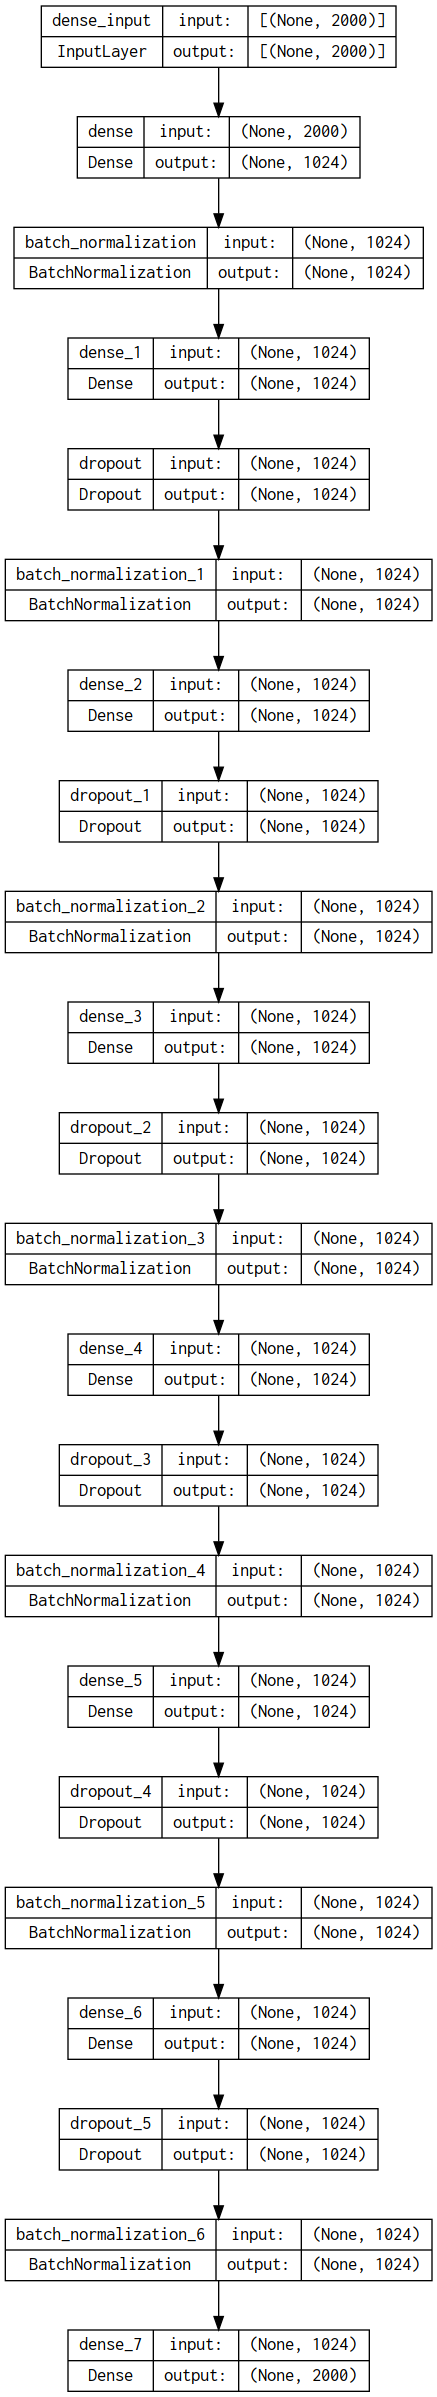

In [15]:
plot_model(model, show_shapes = True)

### e. Make predictions

In [16]:
predictions = model.predict(df_multiome_test_x)

1747/1747 [==============================] - 4s 2ms/step


In [17]:
predictions

array([[ 4.6716523e-01,  2.8549019e-01,  2.6073778e-01, ...,
         4.8186121e-06,  5.6800030e-02,  4.3153364e-02],
       [ 5.2461874e-01,  2.9828852e-01,  3.7949854e-01, ...,
         1.3079989e-06,  3.9444409e-02,  3.2101627e-02],
       [ 5.9929442e-01,  3.1764039e-01,  3.9221925e-01, ...,
        -2.9259536e-07,  3.8366936e-02,  2.2326000e-02],
       ...,
       [ 5.5172700e-01,  3.2935235e-01,  2.9200411e-01, ...,
        -6.0764432e-07,  9.6068539e-02,  1.5226159e-02],
       [ 4.0388319e-01,  2.5908774e-01,  2.8345326e-01, ...,
        -2.5232293e-07,  7.9043552e-02,  1.1830641e-02],
       [ 5.2556491e-01,  3.6678290e-01,  3.6044446e-01, ...,
        -2.5124937e-06,  3.9332747e-02,  4.3528065e-02]], dtype=float32)

In [18]:
predictions = pd.DataFrame(predictions)
predictions.to_excel("predictions_1.xlsx", index = False)

## 2. Apply Keras tuner

In [28]:
import keras_tuner

In [33]:
def build_neural_network(hyperparas):
    
    # 1. Define model
    model = keras.Sequential(
    [
        # input layer
        layers.Dense(units = 1024, activation = "relu", input_shape = [input_dimensions]),
        layers.BatchNormalization(),
        
        # hidden layers
        layers.Dense(units = hyperparas.Int("units", min_value = 32, max_value = 1024, step = 32), # Tune num of units
                     activation = hyperparas.Choice("activation", ["relu", "tanh"])), # Tune activation function
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        layers.Dense(units = hyperparas.Int("units", min_value = 32, max_value = 1024, step = 32), activation = hyperparas.Choice("activation", ["relu", "tanh"])),
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        layers.Dense(units = hyperparas.Int("units", min_value = 32, max_value = 1024, step = 32), activation = hyperparas.Choice("activation", ["relu", "tanh"])),
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        layers.Dense(units = hyperparas.Int("units", min_value = 32, max_value = 1024, step = 32), activation = hyperparas.Choice("activation", ["relu", "tanh"])),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        
        layers.Dense(units = hyperparas.Int("units", min_value = 32, max_value = 1024, step = 32), activation = hyperparas.Choice("activation", ["relu", "tanh"])),
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        layers.Dense(units = hyperparas.Int("units", min_value = 32, max_value = 1024, step = 32), activation = hyperparas.Choice("activation", ["relu", "tanh"])),
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        # output layer
        layers.Dense(output_dimensions)
    ]
    )  
    
    # 2. Compile model
    learning_rate = hyperparas.Float("lr", min_value = 1e-4, max_value = 1e-2, sampling = "log") # Define the optimizer learning rate as a hyperparameter.
    
    model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
        
    loss = tf.keras.losses.MeanSquaredError(),
        
    metrics = [
        tf.keras.metrics.Accuracy(), 
        tf.keras.metrics.MeanSquaredError(), 
        tf.keras.metrics.RootMeanSquaredError(), 
        tf.keras.metrics.CosineSimilarity(axis = 1)
        ]
    )
   
    return model

    # 3. Tune model
tuner = keras_tuner.RandomSearch(
    hypermodel = build_neural_network,
    objective = keras_tuner.Objective("val_mean_squared_error", direction = "min"),
    max_trials = 100,
    overwrite = True,
    directory = "/home/jovyan/project/",
    project_name = "Keras tuner",
)

    # 4. Fit model by searching through hyperparameter space
tuner.search(
    x = train_X, 
    y = train_y.toarray(),
    validation_data = (valid_X, valid_y.toarray()),
)

Trial 100 Complete [00h 00m 24s]
val_mean_squared_error: 0.5828092694282532

Best val_mean_squared_error So Far: 0.576725423336029
Total elapsed time: 00h 41m 54s
INFO:tensorflow:Oracle triggered exit


In [34]:
tuner.results_summary()

Results summary
Results in /home/jovyan/project/Keras tuner
Showing 10 best trials
Trial summary
Hyperparameters:
units: 352
activation: relu
lr: 0.0022855349849264612
Score: 0.576725423336029
Trial summary
Hyperparameters:
units: 544
activation: relu
lr: 0.002956233014862521
Score: 0.5769826173782349
Trial summary
Hyperparameters:
units: 288
activation: relu
lr: 0.002987361022983302
Score: 0.5770519375801086
Trial summary
Hyperparameters:
units: 352
activation: relu
lr: 0.0037018618759039586
Score: 0.5772276520729065
Trial summary
Hyperparameters:
units: 352
activation: relu
lr: 0.003818085074245017
Score: 0.5776122212409973
Trial summary
Hyperparameters:
units: 960
activation: relu
lr: 0.002776217244607687
Score: 0.577614426612854
Trial summary
Hyperparameters:
units: 224
activation: tanh
lr: 0.002788040263541953
Score: 0.5777426958084106
Trial summary
Hyperparameters:
units: 544
activation: relu
lr: 0.002739740054213502
Score: 0.57784503698349
Trial summary
Hyperparameters:
units: 7